In [6]:
#initialization 
import matplotlib.pyplot as plt
import numpy as np

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

#importing qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator

#import basic plot tools
from qiskit.visualization import plot_histogram

In [88]:
def oracle(qc, num_qubits, type='random'):
    '''Applies an oracle of the given type: balanced or constant.'''
    if type == 'constant':
        output = np.random.randint(2)
        if output == 1:
            qc.x(num_qubits)
            return qc
        qc.i(num_qubits)
        return qc
    if type == 'balanced':
        # create a random bitstring to denote marked states
        key = ""
        for _ in range(num_qubits):
            x = str(np.random.randint(2))
            key += x
        # apply an X gate to qubits denoted with '1' in 'key'
        for q in range(len(key)):
            if key[q] == '1':
                qc.x(q)
        #qc.barrier()

        qc.cx(range(num_qubits), num_qubits)
        #qc.barrier()
        # return controlling qubits back to initial state
        for q in range(len(key)):
            if key[q] == '1':
                qc.x(q)
        return qc

    i = np.random.randint(2)
    if i == 1: 
        return oracle(qc, num_qubits, 'balanced')
    else: return oracle(qc, num_qubits, 'constant')

In [94]:
def Deutsch_Jozsa(num_qubits, oracle_type='random'):
    '''Returns a Deutsch_Jozsa circuit for a given number of qubits.'''
    state_qubits = QuantumRegister(num_qubits)
    output_qubit = QuantumRegister(1)
    cbits = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(state_qubits, output_qubit, cbits)
    # set state qubits to |+> and output qubit to |-> state
    qc.h(state_qubits) 
    qc.x(output_qubit)
    qc.h(output_qubit)
    #qc.barrier()
    oracle(qc, num_qubits)
    #qc.barrier()
    qc.h(state_qubits)
    #qc.barrier()
    qc.measure(state_qubits, cbits)
    return qc

qc = Deutsch_Jozsa(2)
qc.draw()

┌───┐          ┌───┐     ┌─┐        
q59_0: ┤ H ├───────■──┤ H ├─────┤M├────────
       ├───┤┌───┐  │  └───┘┌───┐└╥┘┌───┐┌─┐
q59_1: ┤ H ├┤ X ├──┼────■──┤ X ├─╫─┤ H ├┤M├
       ├───┤├───┤┌─┴─┐┌─┴─┐└───┘ ║ └───┘└╥┘
q60_0: ┤ X ├┤ H ├┤ X ├┤ X ├──────╫───────╫─
       └───┘└───┘└───┘└───┘      ║       ║ 
c16: 2/══════════════════════════╩═══════╩═
                                 0       1

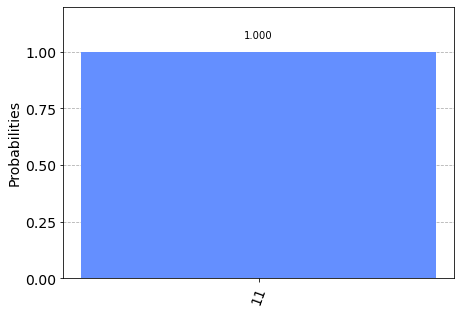

In [95]:
simulator = Aer.get_backend('qasm_simulator')
myobj = assemble(qc, simulator)
result = simulator.run(myobj).result()

plot_histogram(result.get_counts())

In [83]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))                                  
print("Running on current least busy device: ", device)

C:\Users\ivash\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Running on current least busy device:  ibmq_belem


In [98]:
from qiskit.tools.monitor import job_monitor
transpiled_qc = transpile(qc, device)
#transpiled_qc.draw()
job = device.run(assemble(transpiled_qc, device))
job_monitor(job, interval=2)

Job Status: job has successfully run


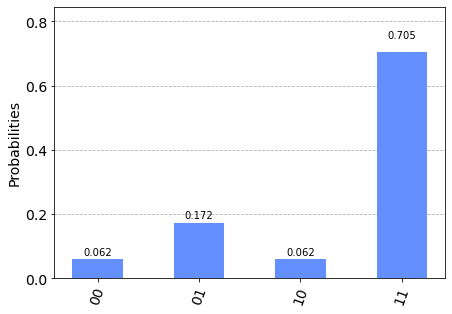

In [99]:
result = job.result()
plot_histogram(result.get_counts())